In [ ]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Optional
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.math as pmmath
import scipy.stats as st
import seaborn as sns

# Set default theme for 'plotnine'.
%matplotlib inline
%config InlineBackend.figure_format='retina'
# Constants
RANDOM_SEED = 847
HDI_PROB = 0.89

pm.__version__

'4.0.0b2'

'4.0.0b2'

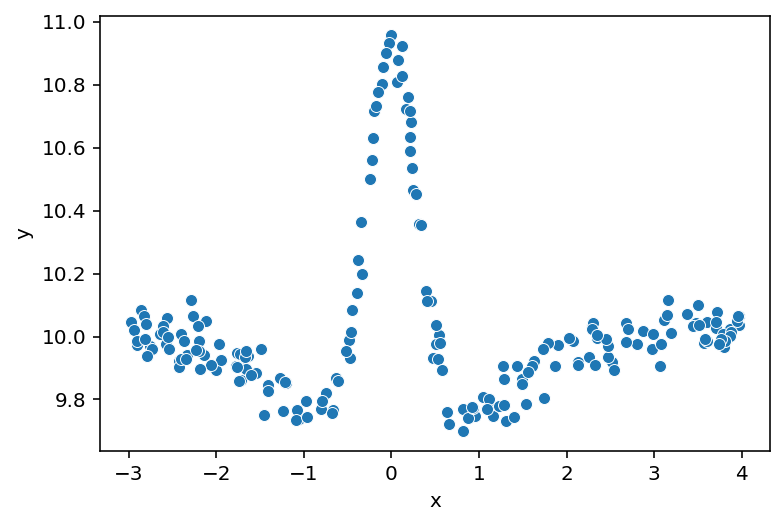

In [7]:
@dataclass
class ModelData:
    """Modeling data."""
    data: pd.DataFrame
    knots: np.ndarray

def diff_of_gaussians(
    x: np.ndarray,
    mus: tuple[float, float],
    sds: tuple[float, float],
    noise: float,
    y_offset: float = 0.0,
    ) -> pd.DataFrame:
    y = (
    st.norm.pdf(x, mus[0], sds[0])
    - st.norm.pdf(x, mus[1], sds[1])
    + np.random.normal(0, noise, size=len(x))
    )
    return pd.DataFrame({"x": x, "y": y + y_offset})

group_pal = {
"a": "#1F77B4",
"b": "#FF7F0E",
"c": "#2CA02C",
"d": "#D62728",
"e": "#9467BD",
}

np.random.seed(RANDOM_SEED)
x = np.random.uniform(-3, 4, 200)
data = diff_of_gaussians(x, (0, 0), (0.3, 1), 0.05, y_offset=10)
sns.scatterplot(data=data, x="x", y="y");

In [8]:
def make_knot_list(data: pd.DataFrame, num_knots: int = 10) -> np.ndarray:
"""Use the quntiles of the data to define knots for a spline."""
return np.quantile(data.x, np.linspace(0, 1, num_knots))
def build_spline(
data: pd.DataFrame,
knot_list: Optional[np.ndarray] = None,
num_knots: int = 10,
intercept: bool = False,
) -> tuple[np.ndarray, DesignMatrix]:
"""Build a spline basis."""
if knot_list is None:
knot_list = make_knot_list(data, num_knots)
B = dmatrix(
f"0 + bs(x, knots=knots, degree=3, include_intercept={intercept})",
{"x": data.x.values, "knots": knot_list[1:-1]},
)
return knot_list, B

knots, B = build_spline(data, intercept=False)
single_curve_data = ModelData(data=data, B=B, knots=knots)

single_curve_data.knots

array([-2.98089976, -2.36504627, -1.67490314, -0.72551484, -0.04744339,
0.50477523, 1.30390392, 2.31655179, 3.43279987, 3.97389701])

single_curve_data.B

DesignMatrix with shape (200, 11)
Columns:
['bs(x, knots=knots, degree=3, include_intercept=False)[0]',
'bs(x, knots=knots, degree=3, include_intercept=False)[1]',
'bs(x, knots=knots, degree=3, include_intercept=False)[2]',
'bs(x, knots=knots, degree=3, include_intercept=False)[3]',
'bs(x, knots=knots, degree=3, include_intercept=False)[4]',
'bs(x, knots=knots, degree=3, include_intercept=False)[5]',
'bs(x, knots=knots, degree=3, include_intercept=False)[6]',
'bs(x, knots=knots, degree=3, include_intercept=False)[7]',
'bs(x, knots=knots, degree=3, include_intercept=False)[8]',
'bs(x, knots=knots, degree=3, include_intercept=False)[9]',
'bs(x, knots=knots, degree=3, include_intercept=False)[10]']
Terms:
'bs(x, knots=knots, degree=3, include_intercept=False)' (columns 0:11)
(to view full data, use np.asarray(this_obj))

np.asarray(single_curve_data.B).shape

(200, 11)

single_curve_data.data.shape

(200, 2)

def plot_spline_basis(model_data: ModelData) -> gg.ggplot:
basis_df = (
pd.DataFrame(model_data.B)
.reset_index(drop=False)
.assign(x=model_data.data.x.values)
.pivot_longer(index=["index", "x"], names_to="basis", values_to="density")
)
return (
gg.ggplot(basis_df, gg.aes(x="x", y="density", color="basis"))
+ gg.geom_line()
+ gg.geom_vline(xintercept=model_data.knots, color="gray", linetype="--")
+ gg.theme(legend_position="none")
)

plot_spline_basis(single_curve_data)

IndentationError: expected an indented block (<ipython-input-8-fbb5d63b12ae>, line 2)